# Clasificación de textos con Procesamiento de Lenguaje Natural y Machine Learning

## Microproyecto 2

### Camilo Rodriguez
### Monica Alvarez

El siguiente script presente clasificar automáticamnte un texto según los 17 objetivos de desarrollo sostenible (ODS) definidos por la La Organización de las Naciones Unidas (ONU). Se harán diferentes pruebas con 3 modelos distintos para poder observar el modelo con mejor precisión de clasificación para los textos.

Se importan las librerías necesarias para el desarrollo del proyecto.

Las principales librerías que se utilizan:

- Scikit-learn: Proporciona herramientas clave para la implementación de algoritmos de machine learning.
- Matplotlib: Utilizado para la visualización de datos, gráficos y resultados del modelo.

In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

A continuación se descargan los recursos necesarios para el procesamiento de lenguaje natural, los principales paquetes usados son:
- Punkt: Tokenizador de oraciones y palabras.
- Stopwords: Descarga la lista de palabras vacías. 
- Wordnet: Descarga la base de datos léxica WordNet para obtener sinónimos, entre otros.

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/melibuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/melibuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/melibuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/melibuntu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Esta celda define una función para calcular y visualizar la matriz de confusión normalizada. Se define aquí para ser reusada múltiples veces.

In [81]:
def plot_confusion_matrix(y_true, y_pred):
    # Calcular la matriz de confusión
    cm = (confusion_matrix(y_true, y_pred)).astype('int')
    
    # Normalizar la matriz de confusión
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 16))
    
    # Crear el heatmap
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
    
    # Configurar las etiquetas y el título
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión Normalizada para Clasificación de ODS')
    
    # Ajustar el diseño y mostrar
    plt.tight_layout()
    plt.show()

A continuación, utilizamos la función `pd.read_excel()` de la librería **pandas** para cargar los ODS definidos.

In [4]:
textos = pd.read_excel('Train_textosODS.xlsx')

In [5]:
np.sort(textos.ODS.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

Procedemos a cargar los textos a procesar y a dividirlo en un set de entrenamiento y otro de prueba usando una proporción 80% - 20%.

In [6]:
X = textos['textos']
y = textos['ODS']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Como se trata de un problema de clasificación, se realiza una expploración inicial de los datos y la distribución de las clases de estos.

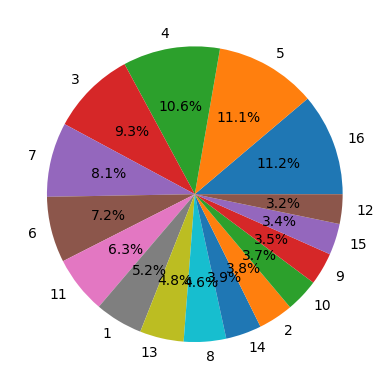

In [7]:
#Contar y normalizar
dfsizes = y_train.value_counts()/y_train.shape[0]
#Crear figura
fig, ax = plt.subplots()
#Pintar
ax.pie(list(dfsizes),labels=list(dfsizes.index) ,autopct='%1.1f%%')
plt.show()

Una vez explorados los datos, se inicia el pre-procesamiento de los textos con el uso con técnicas de PLN.
- Se realiza una tokenización y se transforma el texto a letras minúsculas.
- Elimina las palabras vacías.
- Finalmente, crea una instancia de `WordNetLemmatizer` para lematizar las palabras restantes para obtener su forma base.

In [8]:
def preprocess_text(text):
    # Tokenización
    tokens = word_tokenize(text.lower())
    # Eliminar stopwords y lematizar
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('spanish'))
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words])

Definimos una métrica personalizada para evaluar el rendimiento del modelo de clasificación. Utilizamos `make_scorer` para crear la basada en la métrica F1-Score con ponderación `weighted`, que es útil cuando las clases están desbalanceadas.

In [9]:
scorer = make_scorer(f1_score, average='weighted')

En esta celda, se crea un pipeline que aplica la técnica TF-IDF para la transformación de los textos usando la función de preprocesamiento definida anteriormente.

Posteriormente, se aplica el pipeline a los conjuntos de datos de entrenamiento y prueba.


In [10]:
pipeline_tf = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
])

In [11]:
X_train_tf = pipeline_tf.fit_transform(X_train)

In [22]:
X_test_tf = pipeline_tf.transform(X_test)

### RandomForestClassifier

#### Default Parameters

In [106]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD()),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

Este pipeline transforma los textos, reduce sus dimensiones y entrena el modelo de clasificación `Ramdom Forest`, usando estos parámetros:

- TF-IDF Vectorizer: Convierte los textos en vectores numéricos.
- Truncated SVD: Reduce la dimensionalidad de los datos para mejorar eficiencia.
- El modelo tiene como único parámetro el `class_weight='balanced'` para ajustar automáticamente los pesos entre clases


In [107]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function preprocess_text at 0x7fbb8c457c10>)),
                ('svd', TruncatedSVD()),
                ('clf', RandomForestClassifier(class_weight='balanced'))])

In [108]:
y_pred = pipeline.predict(X_test)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.18      0.14      0.16       101
           2       0.04      0.03      0.03        74
           3       0.22      0.26      0.24       179
           4       0.26      0.31      0.28       205
           5       0.80      0.80      0.80       214
           6       0.75      0.78      0.76       139
           7       0.36      0.49      0.42       158
           8       0.07      0.04      0.05        89
           9       0.16      0.13      0.15        69
          10       0.11      0.07      0.09        70
          11       0.18      0.16      0.17       122
          12       0.07      0.05      0.06        62
          13       0.15      0.16      0.16        93
          14       0.13      0.11      0.12        75
          15       0.10      0.06      0.07        66
          16       0.33      0.39      0.36       216

    accuracy                           0.33      1932
   macro avg       0.24   

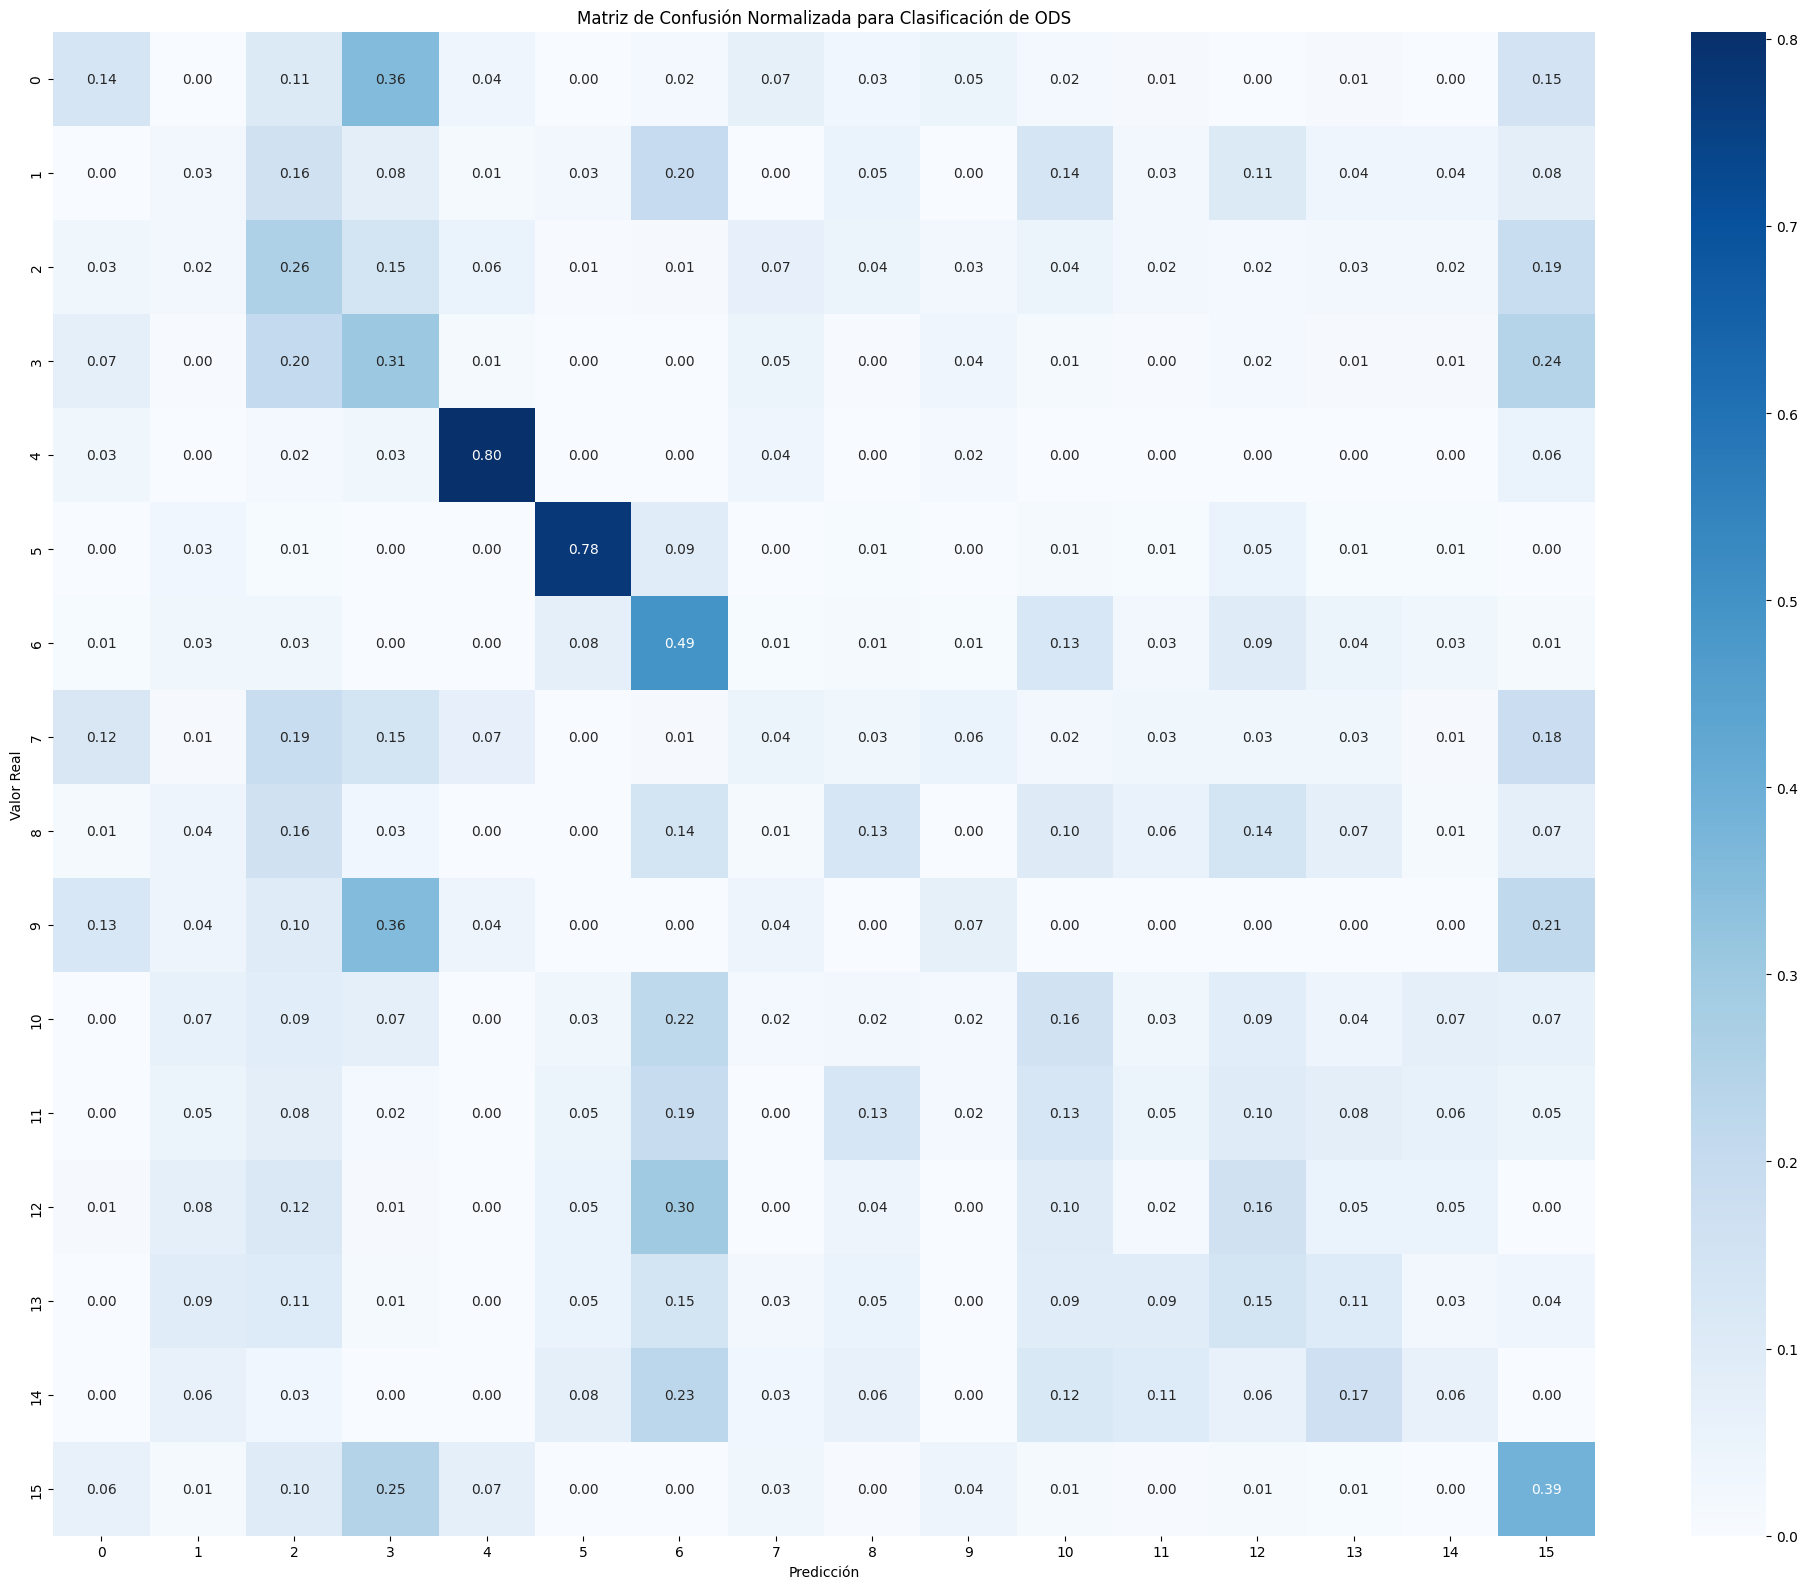

In [110]:
plot_confusion_matrix(y_test, y_pred)

Como se puede observar, este modelo de Random Forest obtiene accuracy de 0.33, lo que indica que el modelo tiene un rendimiento deficiente en la clasificación de los textos.

Además, podemos observar que algunas clases, como la clase 5 y la clase 6, tienen un mejor desempeño (predicciones correctas del 80% y 78%) mientras que, otras clases presentan una mayor dispersión en las predicciones, lo que demuestra la imprecisión del modelo resultante.


#### Hyper Parameters

Dado los resultados anteriores, definimos un nuevo pipeline y realizamos una búsqueda de hiperparámetros usando `GridSearchCV` para optimizar el rendimiento del modelo de clasificación. 
Posteriormente, se hace una búsqueda con validación cruzada (3 folds) para seleccionar los mejores hiperparámetros con base en el scorer declarado al inicio.


In [17]:
pipeline_hyper = Pipeline([
    ('svd', TruncatedSVD()),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

In [18]:
param_grid_rf = {
    'svd__n_iter': [5, 10, 20], # Número de iteraciones para el algoritmo
    'svd__n_components': [50, 100, 300], # Número de componentes (dimensiones reducidas) en los que deseas proyectar los datos

    'clf__n_estimators': [100, 500, 1000], # Número de árboles en el bosque
    'clf__max_depth': [None, 10, 20, 30], # Profundidad máxima de los árboles
    }

In [19]:
search = GridSearchCV(pipeline_hyper, param_grid_rf, scoring=scorer, refit='f1', n_jobs=-1, cv=3)

In [20]:
%%time
search.fit(X_train_tf, y_train)

/var/cache/pypoetry/virtualenvs/app-CfesFmAI-py3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 3min 16s, sys: 4.92 s, total: 3min 20s
Wall time: 11min 39s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('svd', TruncatedSVD()),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20, 30],
                         'clf__n_estimators': [100, 500, 1000],
                         'svd__n_components': [50, 100, 300],
                         'svd__n_iter': [5, 10, 20]},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [43]:
search.best_params_

{'clf__max_depth': None,
 'clf__n_estimators': 1000,
 'svd__n_components': 100,
 'svd__n_iter': 10}

In [94]:
y_pred = search.best_estimator_.predict(X_test_tf)

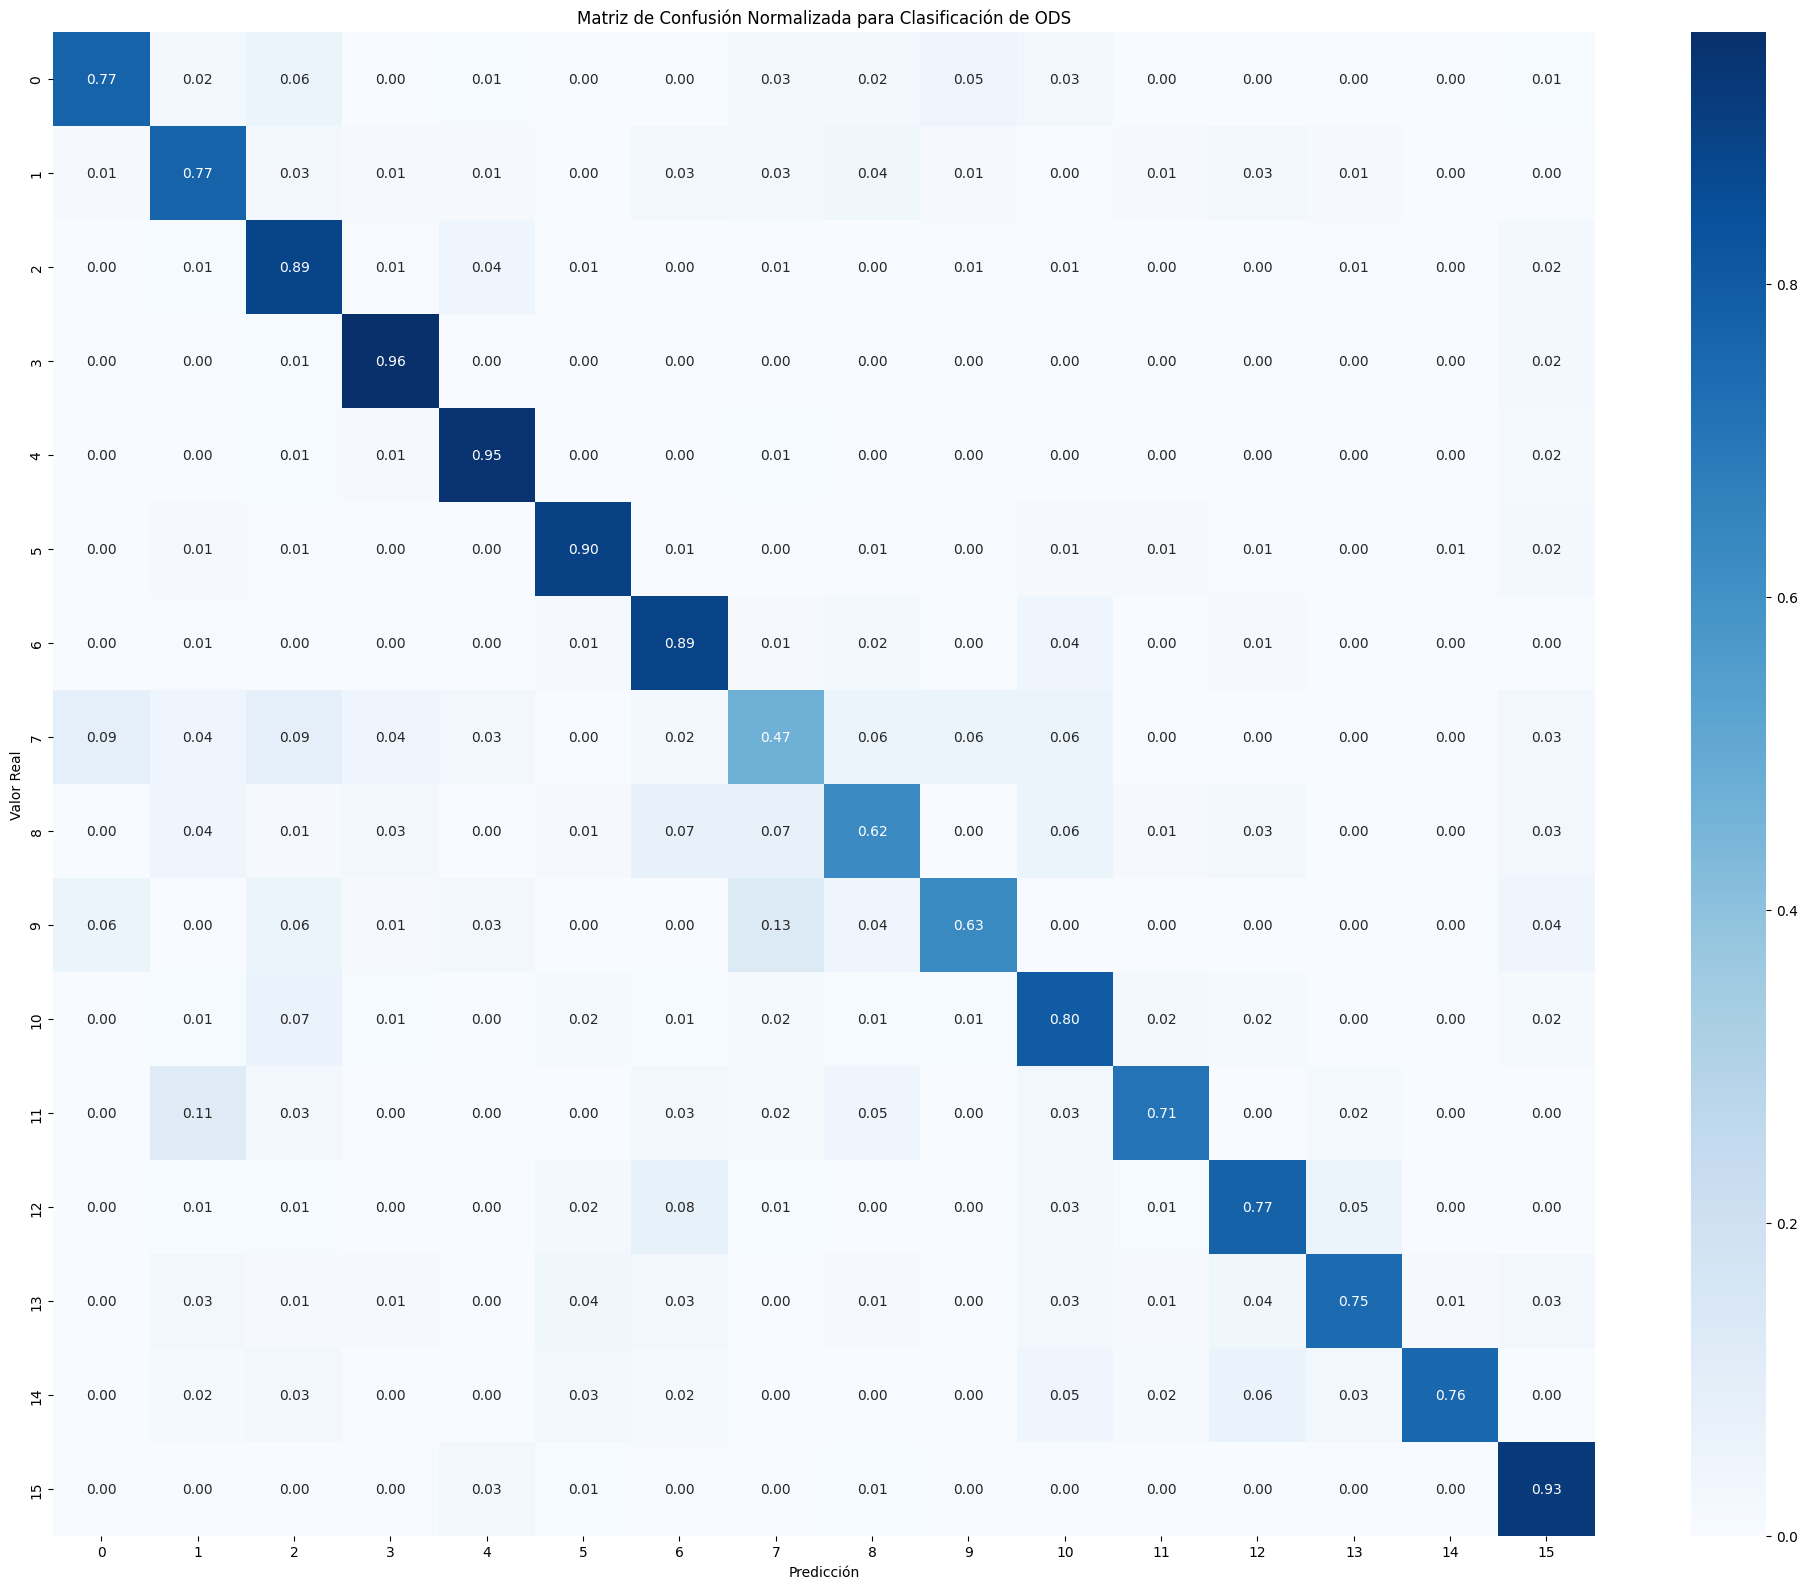

In [95]:
plot_confusion_matrix(y_test, y_pred)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.85      0.77      0.81       101
           2       0.69      0.77      0.73        74
           3       0.80      0.89      0.84       179
           4       0.93      0.96      0.94       205
           5       0.90      0.95      0.92       214
           6       0.89      0.90      0.90       139
           7       0.85      0.89      0.87       158
           8       0.59      0.47      0.53        89
           9       0.64      0.62      0.63        69
          10       0.77      0.63      0.69        70
          11       0.75      0.80      0.77       122
          12       0.81      0.71      0.76        62
          13       0.81      0.77      0.79        93
          14       0.84      0.75      0.79        75
          15       0.96      0.76      0.85        66
          16       0.88      0.93      0.90       216

    accuracy                           0.83      1932
   macro avg       0.81   

Como se puede observar, el modelo optimizado de Random Forest mejoró significativamente su rendimiento. Los resultados muestran un accuracy de 0.83. Mientras que la matriz de confusión normalizada, muestra que la mayoría de las clases tienen predicciones muy precisas, con valores superiores al 0.70 en la diagonal, lo que indica una alta tasa de aciertos. Por ejemplo, las clases 4, 5 y 15 tienen tasas de acierto del 96%, 95% y 93% respectivamente.


### CatBoost

#### Default Parameters

In [26]:
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD()),
    ('clf', CatBoostClassifier(random_state=42, auto_class_weights='Balanced', logging_level='Silent'))
])

Este pipeline transforma los textos, reduce sus dimensiones y entrena el modelo de clasificación `CatBoost`, usando los mismos parámetros usados para el Random Forest. El modelo tiene como parámetro el `auto_class_weights='Balanced'` para ajustar automáticamente los pesos entre clases.

In [27]:
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function preprocess_text at 0x7fbb8c457c10>)),
                ('svd', TruncatedSVD()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7fbb84fbd130>)])

In [96]:
y_pred = pipeline_2.predict(X_test)

In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.27      0.33      0.29       101
           2       0.05      0.05      0.05        74
           3       0.27      0.28      0.28       179
           4       0.32      0.22      0.26       205
           5       0.83      0.84      0.83       214
           6       0.82      0.73      0.77       139
           7       0.48      0.55      0.51       158
           8       0.08      0.03      0.05        89
           9       0.08      0.12      0.09        69
          10       0.16      0.24      0.19        70
          11       0.15      0.07      0.09       122
          12       0.12      0.18      0.15        62
          13       0.25      0.32      0.28        93
          14       0.14      0.12      0.13        75
          15       0.14      0.17      0.15        66
          16       0.44      0.48      0.46       216

    accuracy                           0.36      1932
   macro avg       0.29   

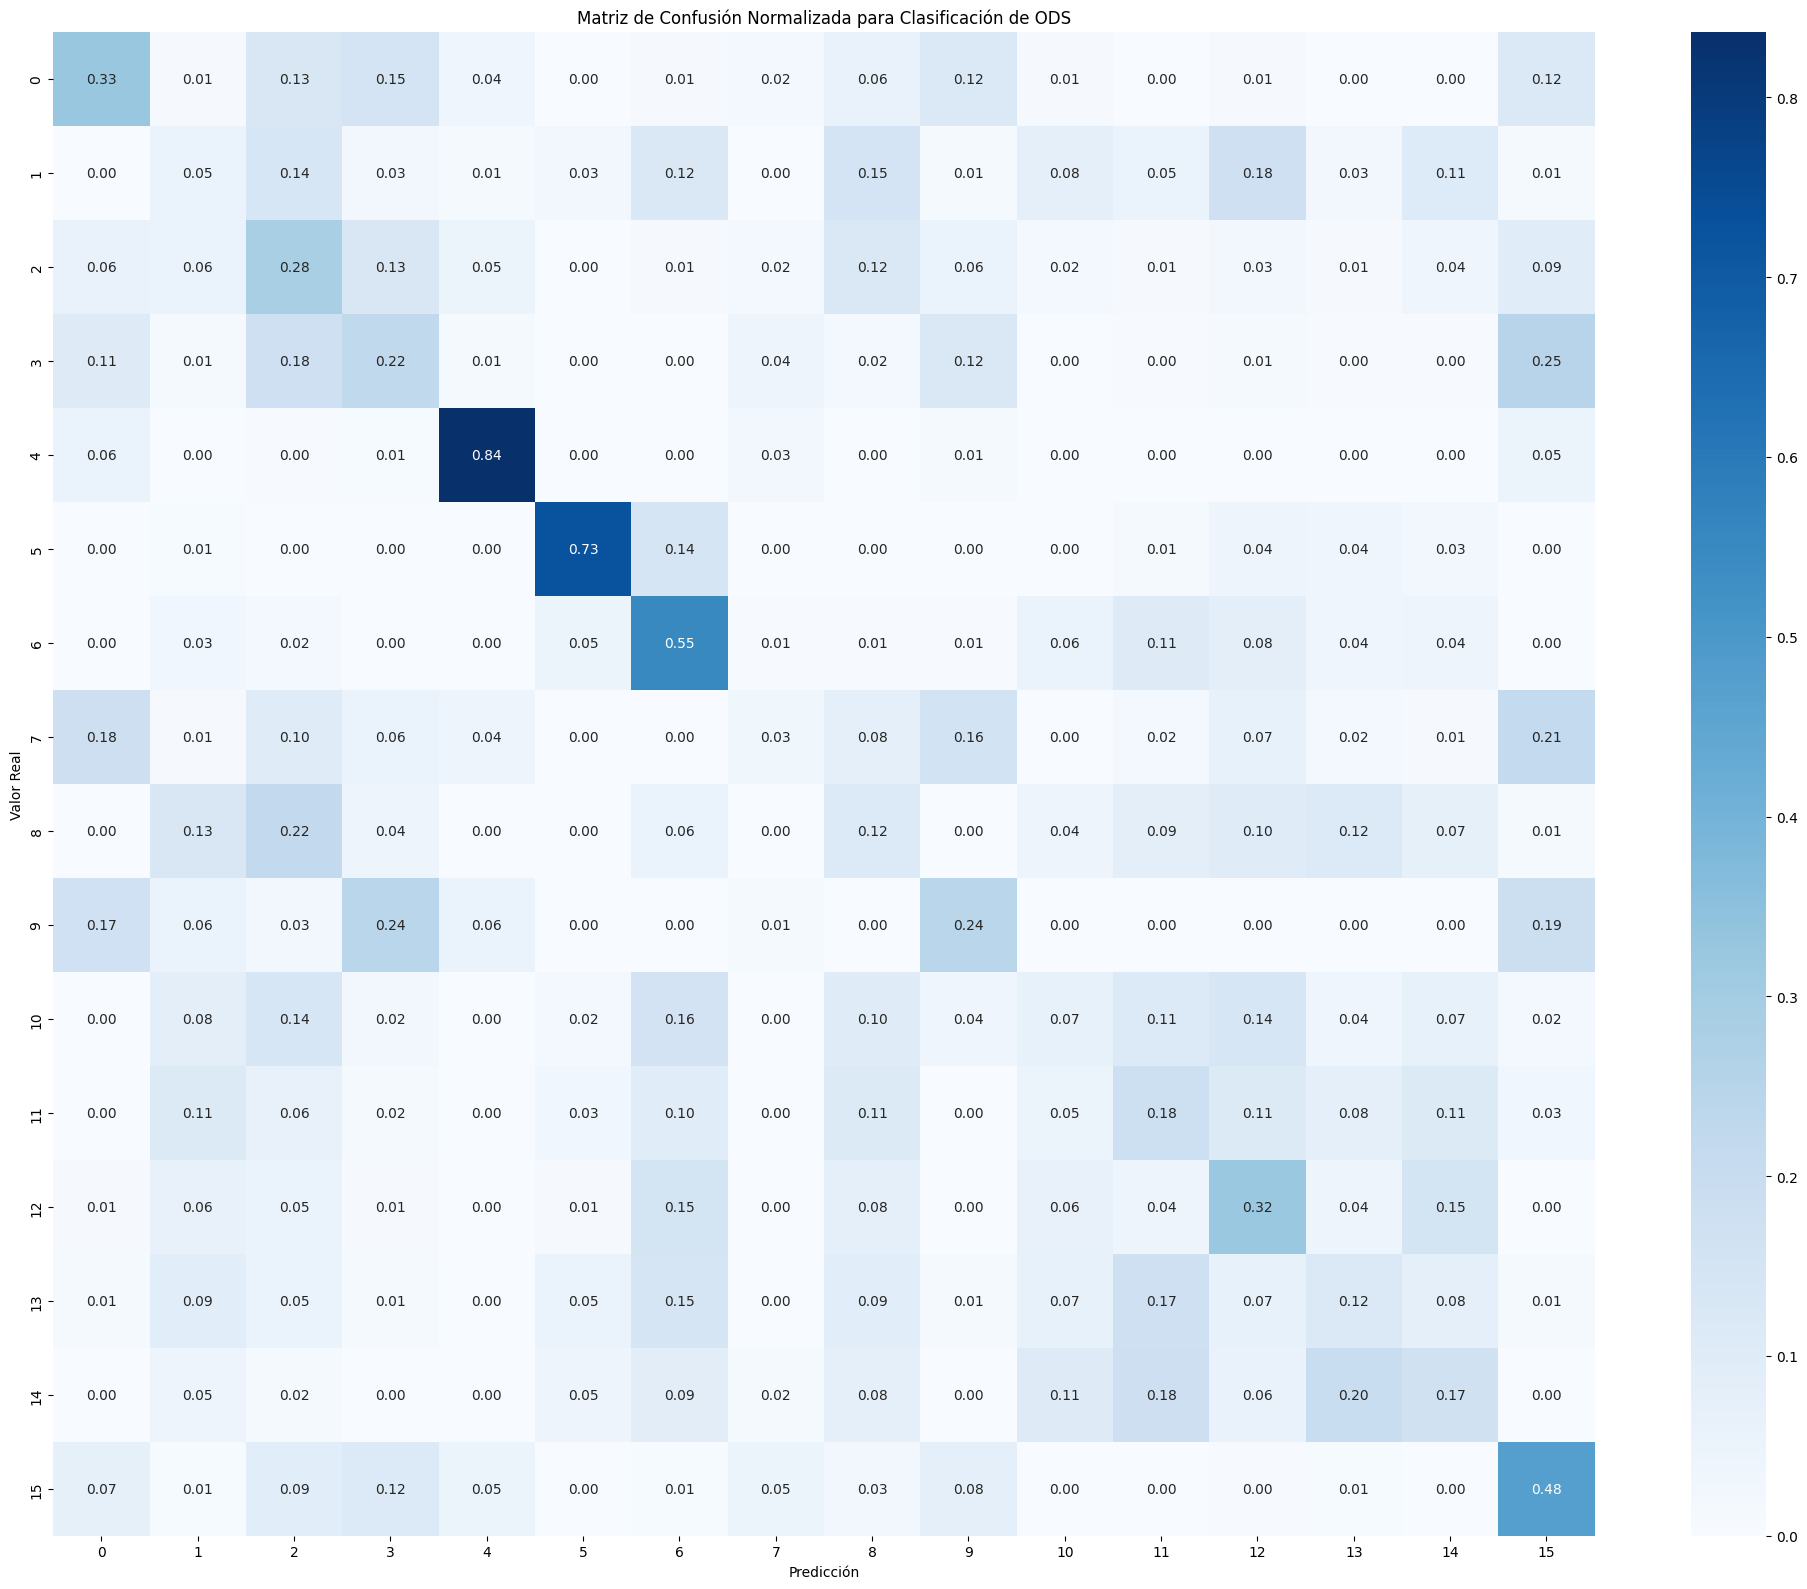

In [98]:
plot_confusion_matrix(y_test, y_pred)

El modelo de CatBoost con los parámetros establecidos (incluyendo el ajuste automático de pesos para manejar clases desbalanceadas) logró un rendimiento muy limitado, indicando un accuracy de 0.36. 

#### Hyper Parameters

Dado los resultados anteriores, definimos un nuevo pipeline y de nuevo realizamos una búsqueda de hiperparámetros usando `GridSearchCV` para optimizar el rendimiento del modelo de clasificación. 
Posteriormente, se hace una búsqueda con validación cruzada (3 folds) para seleccionar los mejores hiperparámetros con base en el scorer declarado al inicio.

In [31]:
pipeline_2_hyper = Pipeline([
    ('svd', TruncatedSVD()),
    ('clf', CatBoostClassifier(random_state=42, auto_class_weights='Balanced', logging_level='Silent'))
])

In [32]:
param_grid_cat = {
    'svd__n_iter': [5, 10, 20], # Número de iteraciones para el algoritmo
    'svd__n_components': [50, 200, 300], # Número de componentes (dimensiones reducidas) en los que deseas proyectar los datos

    'clf__iterations': [100, 500, 1000], # Número de iteraciones o árboles a construir
    'clf__learning_rate': [0.01, 0.1, 0.3], # Tasa de aprendizaje para ajustar el modelo
    #'clf__depth': [4, 6, 8, 10], # Profundidad máxima de los árboles
    }

In [33]:
search_cat = GridSearchCV(pipeline_2_hyper, param_grid_cat, scoring=scorer, refit='f1', n_jobs=-1, cv=3)

In [34]:
%%time
search_cat.fit(X_train_tf, y_train)

/var/cache/pypoetry/virtualenvs/app-CfesFmAI-py3.9/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/var/cache/pypoetry/virtualenvs/app-CfesFmAI-py3.9/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: user 33min 55s, sys: 54 s, total: 34min 49s
Wall time: 1h 48min 50s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('svd', TruncatedSVD()),
                                       ('clf',
                                        <catboost.core.CatBoostClassifier object at 0x7fbb84a5cb20>)]),
             n_jobs=-1,
             param_grid={'clf__iterations': [100, 500, 1000],
                         'clf__learning_rate': [0.01, 0.1, 0.3],
                         'svd__n_components': [50, 200, 300],
                         'svd__n_iter': [5, 10, 20]},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [42]:
search_cat.best_params_

{'clf__iterations': 1000,
 'clf__learning_rate': 0.1,
 'svd__n_components': 200,
 'svd__n_iter': 5}

In [99]:
y_pred_cat = search_cat.best_estimator_.predict(X_test_tf)

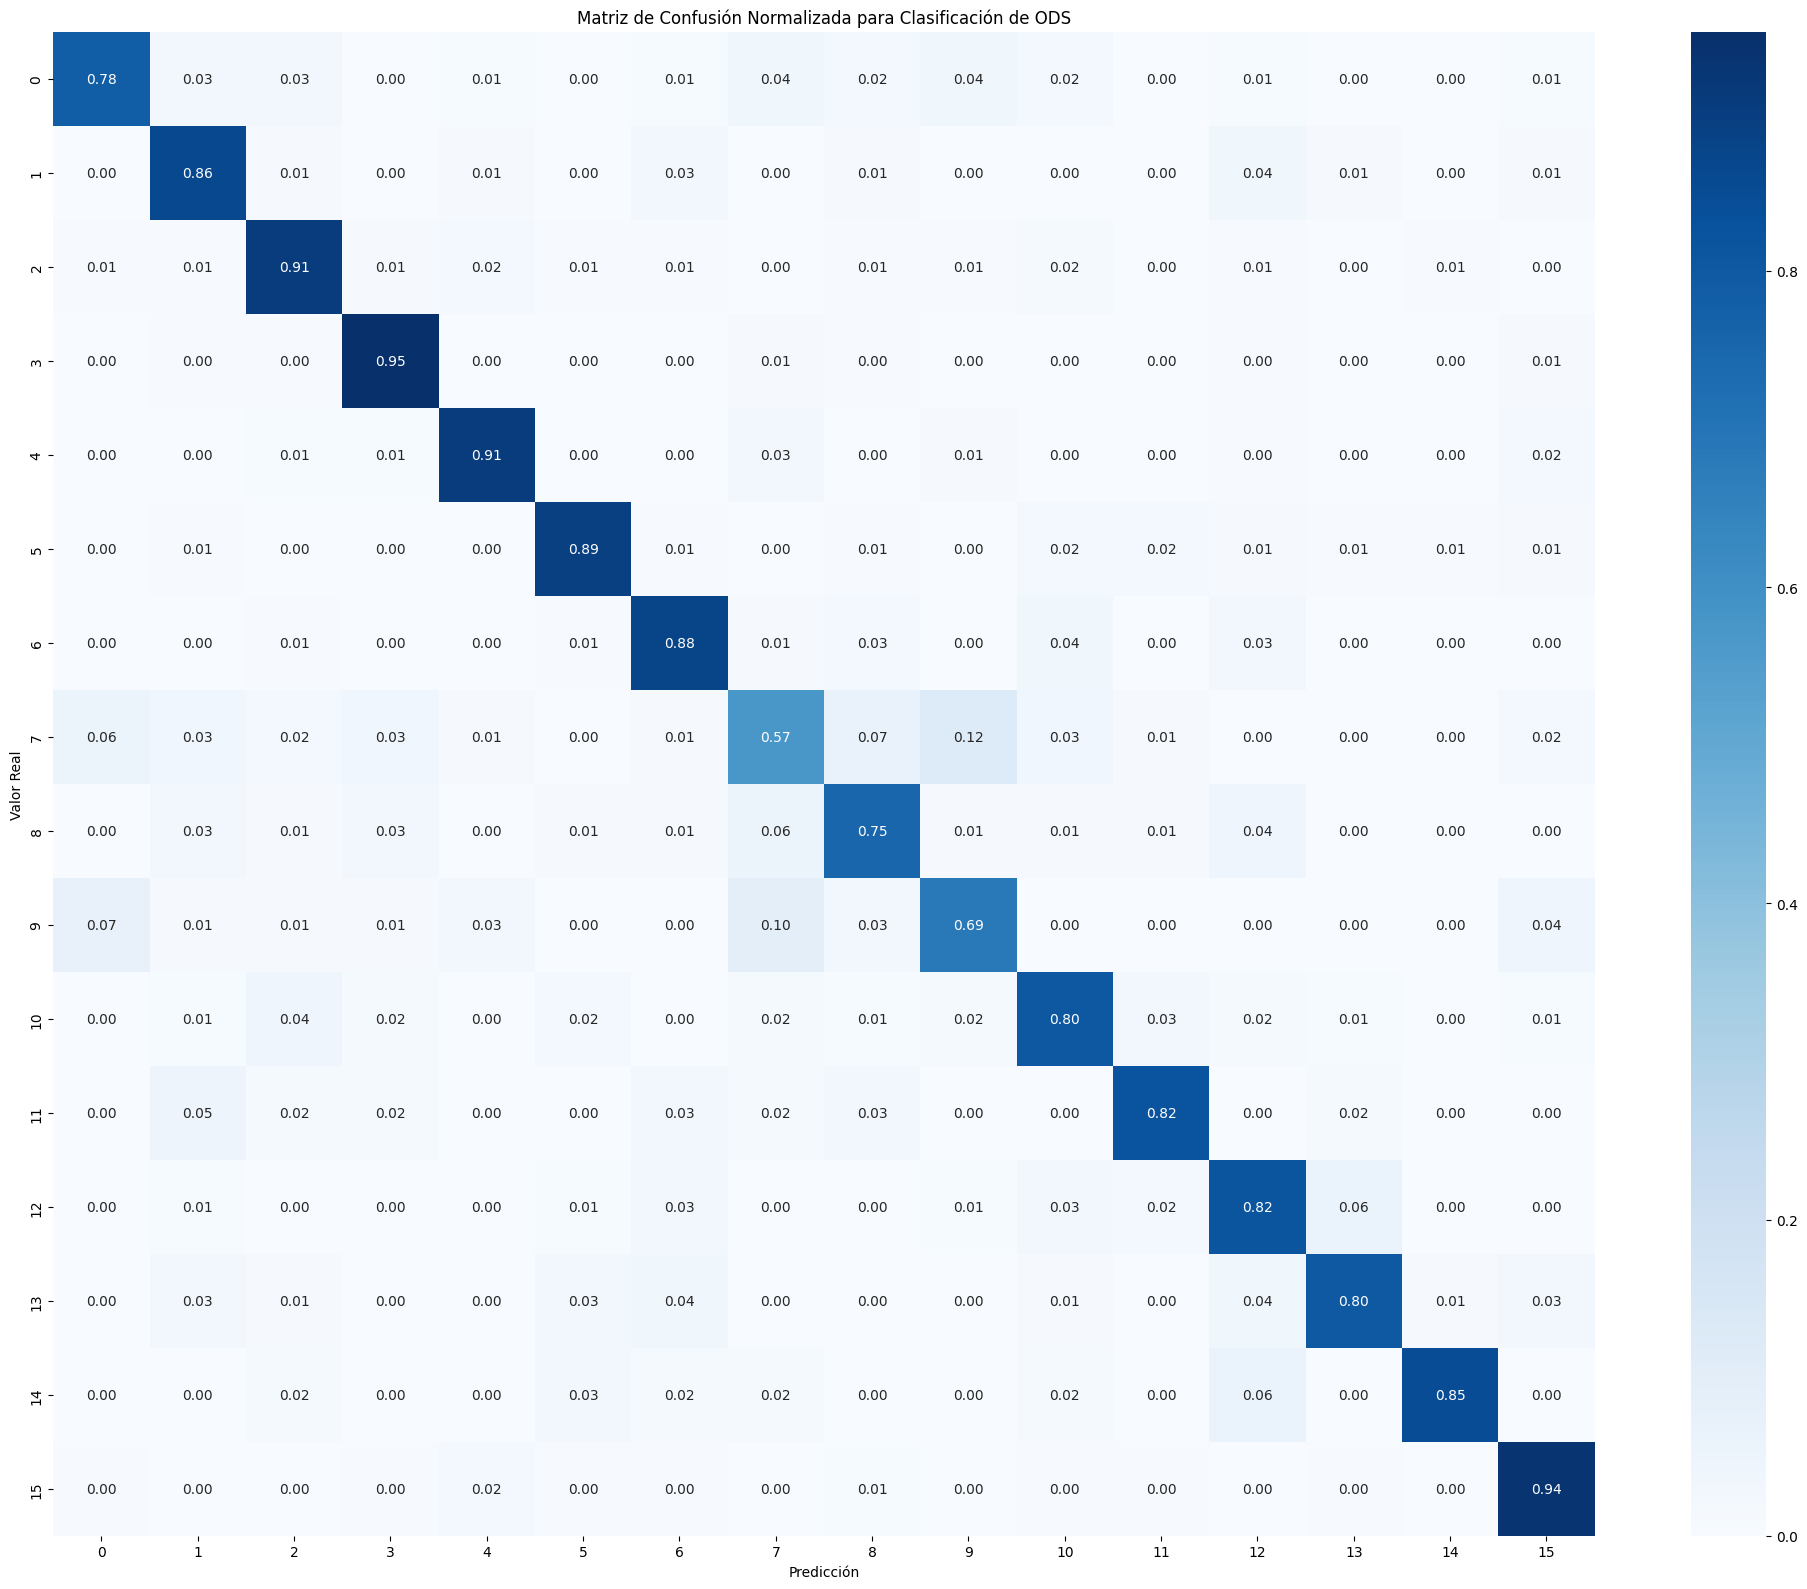

In [100]:
plot_confusion_matrix(y_test, y_pred_cat)

In [101]:
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           1       0.87      0.78      0.82       101
           2       0.77      0.86      0.82        74
           3       0.89      0.91      0.90       179
           4       0.93      0.95      0.94       205
           5       0.93      0.91      0.92       214
           6       0.91      0.89      0.90       139
           7       0.89      0.88      0.89       158
           8       0.62      0.57      0.60        89
           9       0.69      0.75      0.72        69
          10       0.68      0.69      0.68        70
          11       0.80      0.80      0.80       122
          12       0.81      0.82      0.82        62
          13       0.75      0.82      0.78        93
          14       0.85      0.80      0.82        75
          15       0.95      0.85      0.90        66
          16       0.91      0.94      0.92       216

    accuracy                           0.85      1932
   macro avg       0.83   


El modelo CatBoost, después de realizar ajustes en los parámetros ha mejorado significativamente, al encontrar como óptimo el número de componentes `svd__n_components': 200` y un learning rate de **&#945; = 0.1**, logrando un accuracy de 0.85 y su matriz de confusión refleja un mejor desempeño del modelo, con respecto a los modelos anteriores, con altos valores en la diagonal, lo que indica una correcta clasificación de la mayoría de las clases.


### SupportVectorClassifier

#### Default Parameters

In [49]:
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD()),
    ('clf', SVC(class_weight='balanced'))
])

Finalmente, se crea otro pipeline que entrena el modelo de clasificación `Support Vector Classifier SVC`, usando parámetros equivalentes a los modelos anteriores, como parámetro el `class_weight='balanced'` para ajustar automáticamente los pesos entre clases.

In [50]:
pipeline_3.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function preprocess_text at 0x7fbb8c457c10>)),
                ('svd', TruncatedSVD()),
                ('clf', SVC(class_weight='balanced'))])

In [84]:
y_pred = pipeline_3.predict(X_test)

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.24      0.47      0.32       101
           2       0.00      0.00      0.00        74
           3       0.27      0.31      0.29       179
           4       0.34      0.22      0.27       205
           5       0.85      0.82      0.83       214
           6       0.84      0.77      0.80       139
           7       0.51      0.54      0.53       158
           8       0.00      0.00      0.00        89
           9       0.13      0.25      0.17        69
          10       0.00      0.00      0.00        70
          11       0.33      0.01      0.02       122
          12       0.16      0.47      0.23        62
          13       0.21      0.42      0.28        93
          14       0.09      0.01      0.02        75
          15       0.19      0.18      0.18        66
          16       0.39      0.56      0.46       216

    accuracy                           0.38      1932
   macro avg       0.28   

/var/cache/pypoetry/virtualenvs/app-CfesFmAI-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/cache/pypoetry/virtualenvs/app-CfesFmAI-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/cache/pypoetry/virtualenvs/app-CfesFmAI-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

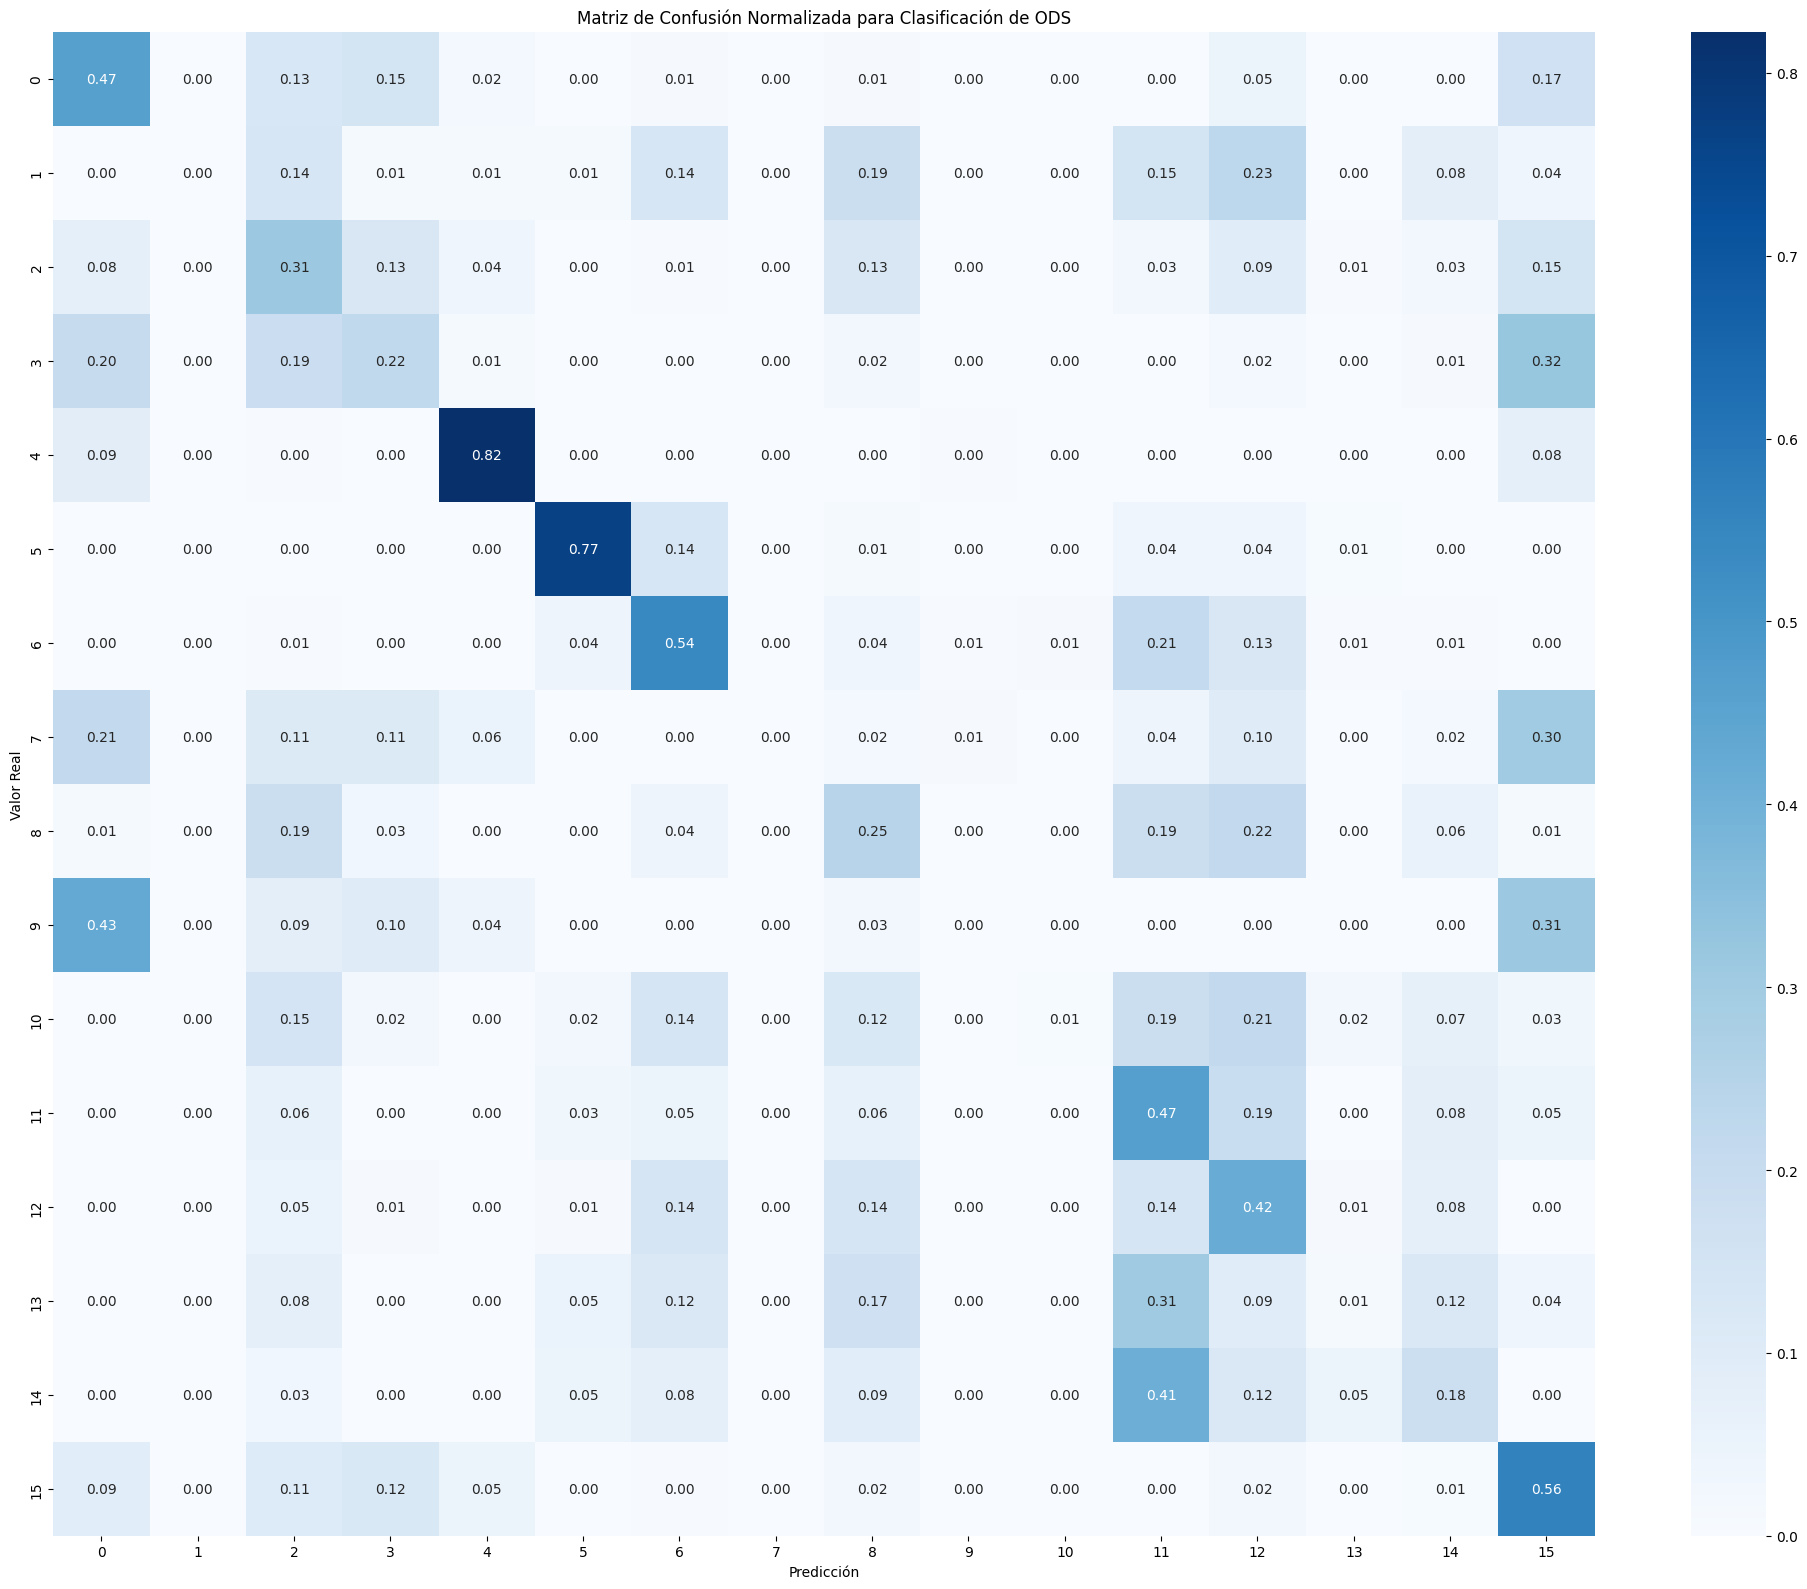

In [86]:
plot_confusion_matrix(y_test, y_pred)

Como se puede observar, al igual que los modelos anteriores el SVC obtiene un rendimiento de apenas 0.38 de accuracy, aunque es mejor que los modelos anteriores sin búqueda de hiperparámetros, no es suficiente para ser un modelo confiable.

#### Hyper Parameters

Finalmente, se implementa para el `SVC`, la busqueda de hiperparámetros con diferentes, para este caso, se probarán diferentes kernel para ver cual ofrece un mejor rendimiento en esta tarea de clasificación.

In [57]:
pipeline_3_hyper = Pipeline([
    ('svd', TruncatedSVD()),
    ('clf', SVC(class_weight='balanced'))
])

In [58]:
param_grid_svc = {
    'svd__n_iter': [5, 10, 20], # Número de iteraciones para el algoritmo
    'svd__n_components': [50, 200, 300], # Número de componentes (dimensiones reducidas) en los que deseas proyectar los dato

    'clf__C': [0.1, 1, 10, 100], # Parámetro de regularización
    'clf__kernel': ['linear', 'rbf', 'poly']# Tipo de kernel a utilizar
} 

In [59]:
search_svc = GridSearchCV(pipeline_3_hyper, param_grid_svc, scoring=scorer, refit='f1', n_jobs=-1, cv=3)

In [60]:
%%time
search_svc.fit(X_train_tf, y_train)

CPU times: user 2min 43s, sys: 8.26 s, total: 2min 51s
Wall time: 5min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('svd', TruncatedSVD()),
                                       ('clf', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__kernel': ['linear', 'rbf', 'poly'],
                         'svd__n_components': [50, 200, 300],
                         'svd__n_iter': [5, 10, 20]},
             refit='f1',
             scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [64]:
search_svc.best_params_

{'clf__C': 100,
 'clf__kernel': 'rbf',
 'svd__n_components': 300,
 'svd__n_iter': 10}

In [61]:
y_pred_svc = search_svc.best_estimator_.predict(X_test_tf)

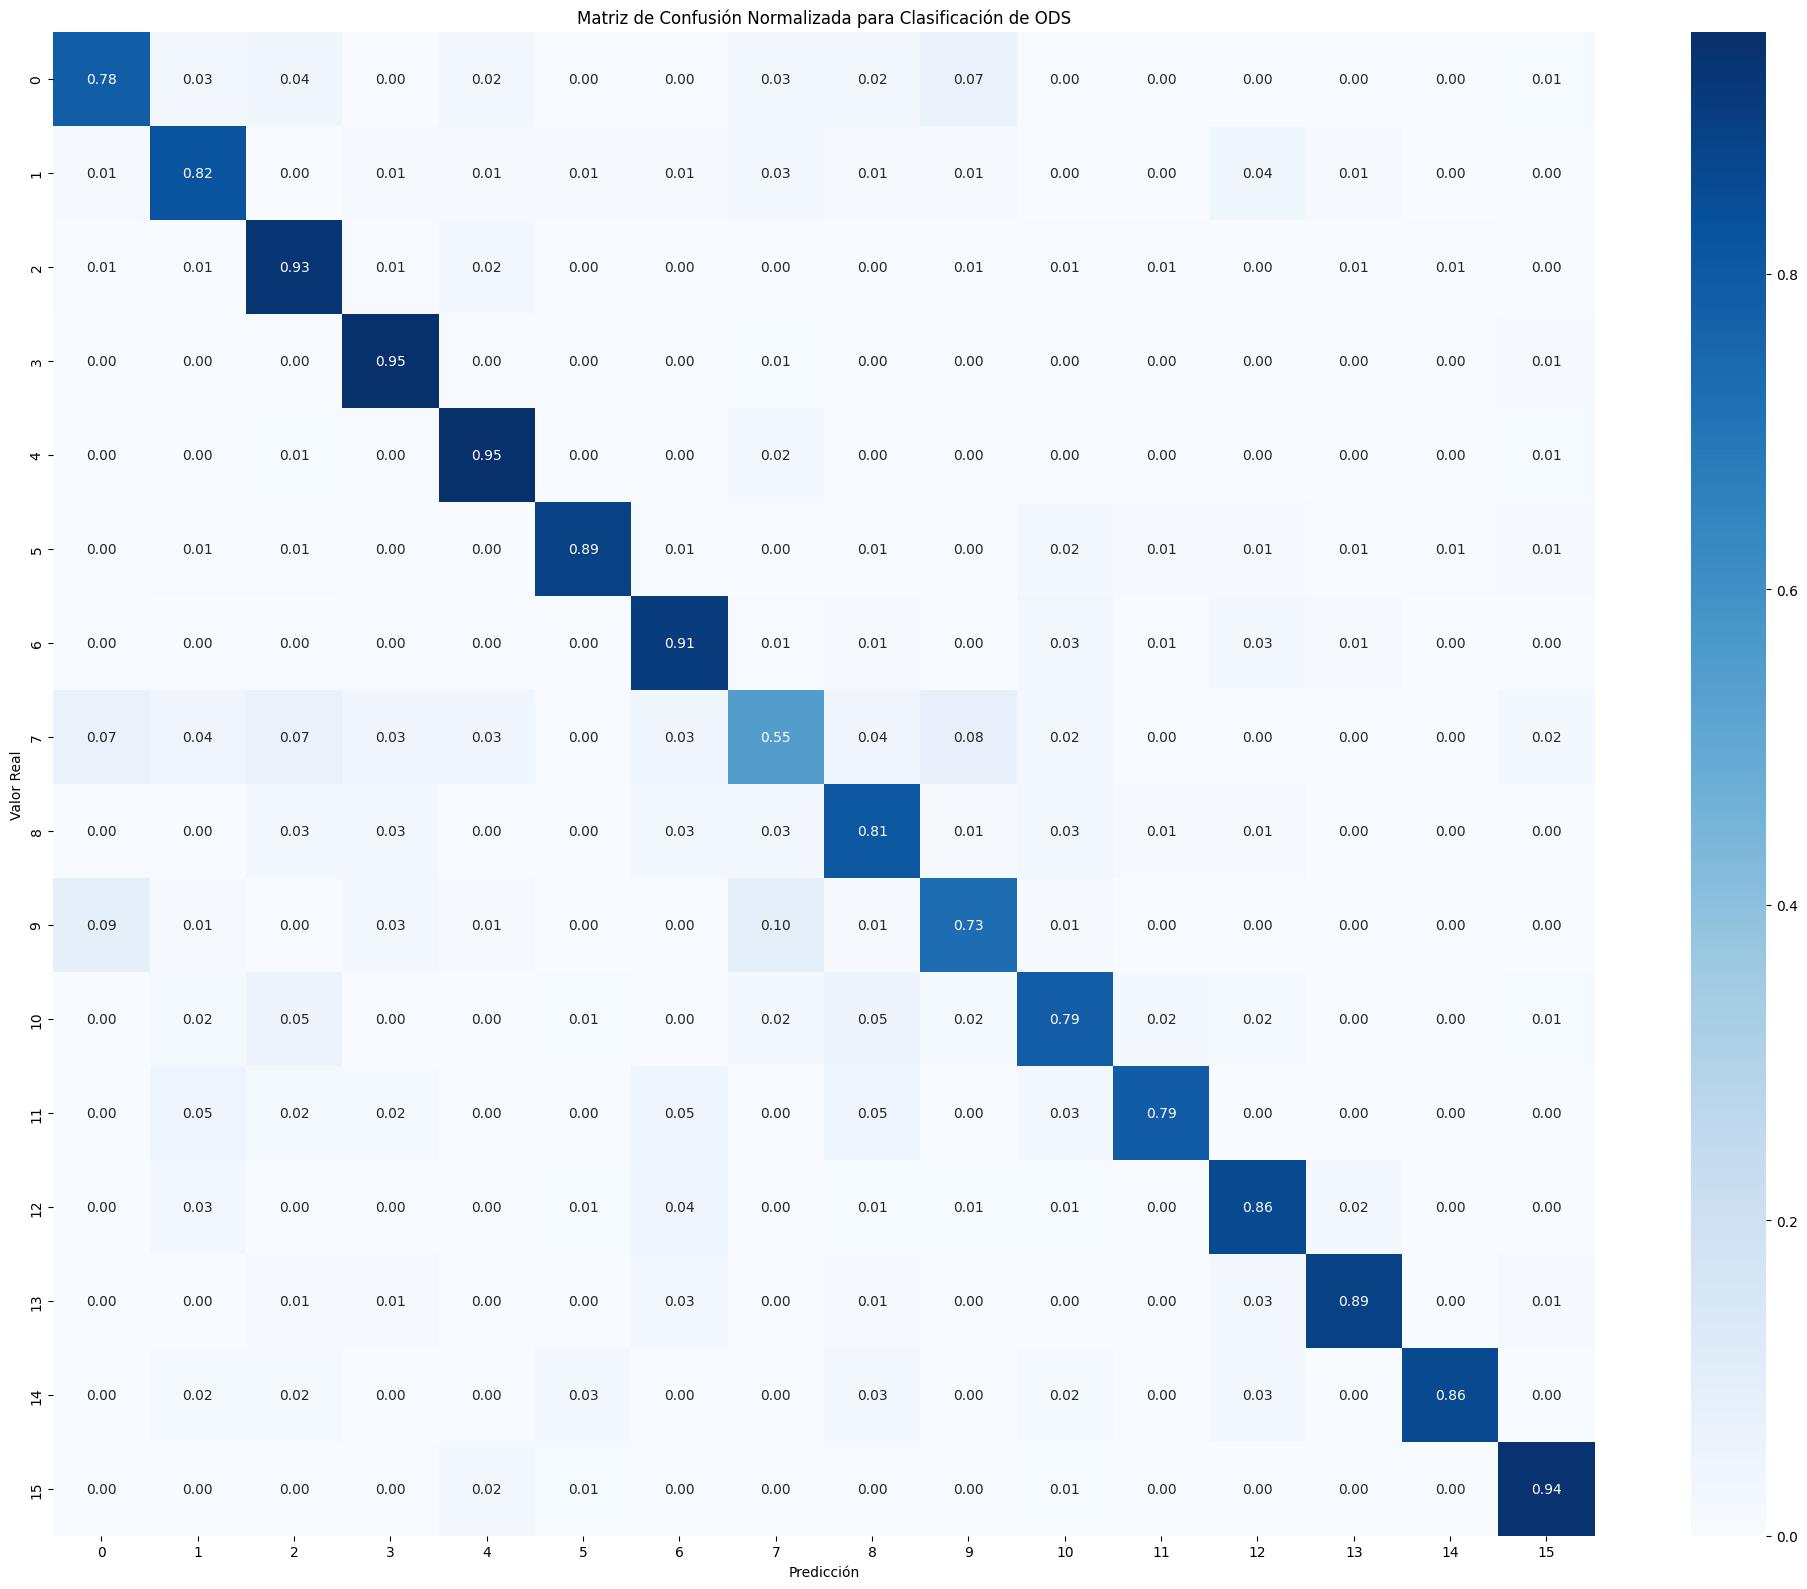

In [83]:
plot_confusion_matrix(y_test, y_pred_svc)

In [63]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           1       0.85      0.78      0.81       101
           2       0.76      0.82      0.79        74
           3       0.87      0.93      0.90       179
           4       0.94      0.95      0.94       205
           5       0.92      0.95      0.94       214
           6       0.95      0.89      0.92       139
           7       0.90      0.91      0.90       158
           8       0.66      0.55      0.60        89
           9       0.68      0.81      0.74        69
          10       0.71      0.73      0.72        70
          11       0.82      0.79      0.80       122
          12       0.86      0.79      0.82        62
          13       0.82      0.86      0.84        93
          14       0.89      0.89      0.89        75
          15       0.95      0.86      0.90        66
          16       0.94      0.94      0.94       216

    accuracy                           0.87      1932
   macro avg       0.85   

Como se puede observar, se obtuvo que el kernel `rbf` con regularización `c=100`, alcanzó un accuracy de 0.87, lo que indica un buen rendimiento en la clasificación. Asimismo, la mayoría de las predicciones correctas se encuentran en la diagonal de la matriz de confusión, mostrando que el modelo clasifica bien la mayoría de las clases.

Encontrando que el mejor modelo para esta tarea de clasificación es el SVC, se procede a crear un pipeline, que entrene el modelo con los hiperparámetros encontrados en la búsqueda anterior.

### Creación mejor pipeline 

In [102]:
pipeline_final = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=preprocess_text)),
    ('svd', TruncatedSVD(n_components=300, n_iter=10)),
    ('clf', SVC(class_weight='balanced', C =100, kernel= 'rbf'))
])

In [103]:
pipeline_final.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function preprocess_text at 0x7fbb8c457c10>)),
                ('svd', TruncatedSVD(n_components=300, n_iter=10)),
                ('clf', SVC(C=100, class_weight='balanced'))])

In [104]:
y_pred = pipeline_final.predict(X_test)

In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.81      0.85       101
           2       0.78      0.84      0.81        74
           3       0.88      0.92      0.90       179
           4       0.94      0.96      0.95       205
           5       0.92      0.95      0.94       214
           6       0.94      0.90      0.92       139
           7       0.85      0.90      0.87       158
           8       0.64      0.55      0.59        89
           9       0.68      0.80      0.73        69
          10       0.73      0.73      0.73        70
          11       0.82      0.77      0.80       122
          12       0.86      0.82      0.84        62
          13       0.82      0.84      0.83        93
          14       0.90      0.87      0.88        75
          15       0.93      0.86      0.90        66
          16       0.95      0.94      0.95       216

    accuracy                           0.87      1932
   macro avg       0.85   

## Conclusiones
